<a href="https://colab.research.google.com/github/pykeen/pykeen/blob/master/notebooks/hello_world/hello_world.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hello, World!

This notebook is about your first steps with knowledge graph embedding models in PyKEEN.

You'll get to do the following:

1. train a model
2. evaluate how good it learned
3. turn it around and start making predictions.

In [1]:
# Install packages if they're not already found
! pip install --upgrade pip
! python -c "import pykeen" || pip install git+https://github.com/pykeen/pykeen.git
! python -c "import wordcloud" || pip install wordcloud

In [2]:
import os

import matplotlib.pyplot as plt
import torch

import pykeen
from pykeen.datasets import Nations
from pykeen.pipeline import pipeline

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [3]:
pykeen.env()

Key,Value
OS,posix
Platform,Darwin
Release,21.5.0
Time,Fri Aug 19 15:10:28 2022
Python,3.10.4
PyKEEN,1.9.1-dev
PyKEEN Hash,e7851f61
PyKEEN Branch,fix-word-cloud
PyTorch,1.11.0
CUDA Available?,false


## Train a Model

More tutorials on training your first model can be found [here](https://pykeen.readthedocs.io/en/latest/first_steps.html).

You can try switching out the model, add a `loss`, a `regularizer`, or switch the training assumption from `sLCWA` to `LCWA`. Each also has their own hyper-parameters, though PyKEEN tries to have reasonable defaults for you. The most useful one to change is the `num_epochs` in the `training_kwargs`, which is already below.

In [4]:
result = pipeline(
    dataset="Nations",
    model="PairRE",
    # Training configuration
    training_kwargs=dict(
        num_epochs=200,
        use_tqdm_batch=False,
    ),
    # Runtime configuration
    random_seed=1235,
    device="cpu",
)

Training epochs on cpu:   0%|          | 0/200 [00:00<?, ?epoch/s]

INFO:pykeen.evaluation.evaluator:Currently automatic memory optimization only supports GPUs, but you're using a CPU. Therefore, the batch_size will be set to the default value.
INFO:pykeen.evaluation.evaluator:No evaluation batch_size provided. Setting batch_size to '32'.


Evaluating on cpu:   0%|          | 0.00/201 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.06s seconds


Save the trained model (which contains the triples and all of the learned parameters), the results from training, and all of the experimental metadata.

In [5]:
save_location = "results"  # this directory
result.save_to_directory(save_location)
os.listdir(save_location)

INFO:pykeen.triples.triples_factory:Stored TriplesFactory(num_entities=14, num_relations=55, create_inverse_triples=False, num_triples=1592, path="/Users/cthoyt/dev/pykeen/src/pykeen/datasets/nations/train.txt") to file:///Users/cthoyt/dev/pykeen/notebooks/hello_world/results/training_triples
INFO:pykeen.pipeline.api:Saved to directory: file:///Users/cthoyt/dev/pykeen/notebooks/hello_world/results


['training_triples', 'results.json', 'metadata.json', 'trained_model.pkl']

In [6]:
# How to look at the model
model = result.model
model

PairRE(
  (loss): MarginRankingLoss(
    (margin_activation): ReLU()
  )
  (interaction): PairREInteraction()
  (entity_representations): ModuleList(
    (0): Embedding(
      (_embeddings): Embedding(14, 200)
    )
  )
  (relation_representations): ModuleList(
    (0): Embedding(
      (_embeddings): Embedding(55, 200)
    )
    (1): Embedding(
      (_embeddings): Embedding(55, 200)
    )
  )
  (weight_regularizers): ModuleList()
)

In [7]:
# How to look at the triples
tf = result.training
tf

TriplesFactory(num_entities=14, num_relations=55, create_inverse_triples=False, num_triples=1592, path="/Users/cthoyt/dev/pykeen/src/pykeen/datasets/nations/train.txt")

In [8]:
tf.num_entities, tf.num_relations, tf.num_triples

(14, 55, 1592)

## Evaluating the Results

Check that the loss is going down (and not oscillating) by plotting in the notebook.

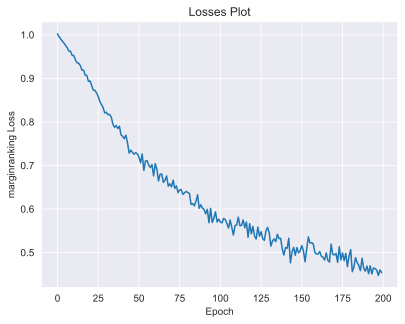

In [9]:
result.plot_losses()
plt.show()

Look at the result. These are pretty tricky to interpret, so remember:

- adjusted mean rank is between [0, 2]. Closer to 0 is better!
- mean rank is a positive integer, with a bound based on the number of entities. Closer to 0 is better!
- hits@k is reported between [0, 1] and interpreted as a percentage. Closer to 1 is better!

In [10]:
result.metric_results.to_df()

,Side,Type,Metric,Value
0,head,optimistic,z_arithmetic_mean_rank,15.143086
1,tail,optimistic,z_arithmetic_mean_rank,16.974819
2,both,optimistic,z_arithmetic_mean_rank,22.729568
3,head,realistic,z_arithmetic_mean_rank,15.143086
4,tail,realistic,z_arithmetic_mean_rank,16.974819
...,...,...,...,...
220,tail,realistic,adjusted_hits_at_k,1.000000
221,both,realistic,adjusted_hits_at_k,0.953127
222,head,pessimistic,adjusted_hits_at_k,0.905599
223,tail,pessimistic,adjusted_hits_at_k,1.000000


## Turn it around: make predictions

It's very difficult to interpret KGEMs statistically, so it's best to sort order the predictions by their scores. All interaction functions in PyKEEN have been implemented such that the higher the score (or less negative the score), the more likely a triple is to be true.

Before making any predictions, we're goign to show some word clouds of the entities and relations in the Nations dataset, with size corresponding to frequency of appearance in triples.

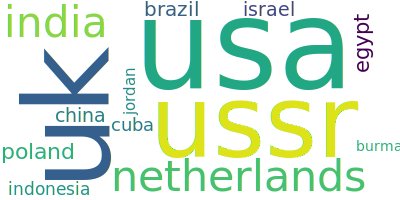

In [11]:
tf.entity_word_cloud()

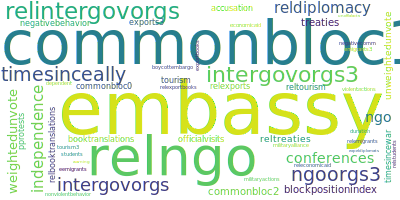

In [12]:
tf.relation_word_cloud()

In [13]:
testing_mapped_triples = Nations().testing.mapped_triples.to(model.device)

In [14]:
# Who do we predict brazil participates in inter-governmental organizations with?
model.get_tail_prediction_df("brazil", "intergovorgs", triples_factory=tf, testing=testing_mapped_triples)

,tail_id,tail_label,score,in_training,in_testing
5,5,india,-2.114373,True,False
12,12,usa,-2.119678,True,False
9,9,netherlands,-2.138442,True,False
11,11,uk,-2.192534,True,False
4,4,egypt,-2.437390,True,False
6,6,indonesia,-2.617149,True,False
10,10,poland,-2.621141,False,True
7,7,israel,-2.652526,True,False
3,3,cuba,-2.981478,False,True
13,13,ussr,-3.058180,False,False


In [15]:
# Automatically filter out non-novel predictions (e.g. in training or in testing is True)
model.get_tail_prediction_df(
    "brazil", "intergovorgs", triples_factory=tf, testing=testing_mapped_triples, remove_known=True
)

,tail_id,tail_label,score
13,13,ussr,-3.058180
0,0,brazil,-3.211353
2,2,china,-3.242816
1,1,burma,-3.261366
8,8,jordan,-3.528769


In [16]:
# Who do we predict to have a conference with brazil?
model.get_head_prediction_df("conferences", "brazil", triples_factory=tf, testing=testing_mapped_triples)

,head_id,head_label,score,in_training,in_testing
10,10,poland,-2.129169,True,False
3,3,cuba,-2.224976,True,False
13,13,ussr,-2.242457,True,False
12,12,usa,-2.284824,True,False
5,5,india,-2.410077,True,False
11,11,uk,-2.813856,False,False
6,6,indonesia,-2.837616,False,False
2,2,china,-2.893122,False,False
4,4,egypt,-2.944993,False,False
9,9,netherlands,-2.984741,False,False


In [17]:
# Score all triples
model.get_all_prediction_df(triples_factory=tf, testing=testing_mapped_triples)

scoring:   0%|          | 0.00/770 [00:00<?, ?batch/s]

,head_id,head_label,relation_id,relation_label,tail_id,tail_label,score,in_training,in_testing
0,5,india,2,attackembassy,6,indonesia,-1.138494,True,False
1,11,uk,24,militaryalliance,9,netherlands,-1.231564,True,False
2,7,israel,22,lostterritory,8,jordan,-1.267689,True,False
3,10,poland,22,lostterritory,13,ussr,-1.276796,True,False
4,13,ussr,6,commonbloc0,12,usa,-1.294233,True,False
...,...,...,...,...,...,...,...,...,...
10775,12,usa,13,eemigrants,1,burma,-4.371924,False,False
10776,5,india,19,independence,5,india,-4.388505,False,False
10777,2,china,27,ngo,2,china,-4.428998,False,False
10778,0,brazil,12,economicaid,13,ussr,-4.489155,False,False
